# Costa Rica HPC School Hands On 


In [4]:
import numba
import mpi4py
import numpy as np
import matplotlib.pyplot as plt
from numba import prange
import ipyparallel as ipp

## 2D Transient Laplace equation


The transient Laplace equation in 2D, also known as the heat equation or diffusion equation, is a partial differential equation that describes how a quantity such as temperature or concentration changes over time and space. It is given by: 

$$\frac{\partial u}{\partial t} = \alpha\left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right)$$

where: 

* $u(x,y,t)$ is the unknown function representing the quantity being modeled (e.g., temperature or concentration).
* $t$ represents time.
* $x$ and $y$ represent spatial coordinates.
* $\alpha$ is the diffusion coefficient, a positive constant representing the rate at which the quantity diffuses.

The equation describes how the quantity $u$ changes over time as a result of diffusion and the boundary conditions of the specific problem. 

The transient Laplace equation is widely used in various fields, including physics, engineering, biology, and environmental science, to model phenomena such as heat conduction, chemical diffusion, and population dynamics, among others. Solving this equation allows researchers and engineers to predict how a system's behavior evolves over time. Various numerical methods, such as finite difference, finite element, and spectral methods, can be employed to solve the transient Laplace equation in practical applications.

## The Problem

$$\frac{\partial u}{\partial t} = \alpha\left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right), \quad\quad x \in (0,L_x) \quad\quad y \in (0,L_y) \quad\quad t \in (0, T)$$

Initial condition:

$$u(x,y, 0) = 0$$

Boundary conditions:

$$u(0,y, t) = h$$
$$u(x,0, t) = h$$
$$u(x,L_y, t) = h$$

## Discretization of the 2D Heat equation

![image.png](Discretization.png)

## Simulation Domain

![image.png](stencil.png)

In [5]:
# simulation parameter definition 

# number of divisions in every coordinate
Nx = 100
Ny = 100
Nt = 250

# physical dimensions of simulation domain
Lx = 1.0
Ly = 1.0
T = 50

# discretization of domain
dx = Lx/Nx
dy = Ly/Ny
dt = T/Nt

# establish helpful coefficients
alpha = 1.0e-4
Cx = alpha*dt/dx**2
Cy = alpha*dt/dy**2
X, Y = np.meshgrid(np.linspace(0, Lx, Nx),
                   np.linspace(0, Ly, Ny), 
                   indexing='ij')

# boundary condition value
h = 300 #K

In [6]:
# the domain is initialized as a Nx x Ny matrix
def initialize_domain_serial(Nx, Ny):
    u = np.zeros((Nx, Ny))
    return u

In [7]:
# normal way of implementing the laplace kernel (expensive)
def laplace_stencil2D(u, Cx, Cy):
    Nx, Ny = u.shape
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            u[i,j] += (Cx*(u[i-1,j] - 2*u[i,j] + u[i+1, j]) +
                Cy*(u[i,j-1] - 2*u[i,j] + u[i,j+1]))
    return u

In [8]:
# the stencil is applied using vectorization within numpy 
def laplace_stencil2D_numpy(u, Cx, Cy):
    return (u[1:-1, 1:-1] + Cx *(u[:-2,1:-1] - 2.0*u[1:-1, 1:-1] + u[2:,1:-1]) +
            Cy *(u[1:-1,:-2] - 2.0*u[1:-1, 1:-1] + u[1:-1,2:]))

In [9]:
#numba accelerated stencil computation (fastest)
@numba.stencil
def laplace_stencil2D_numba(u, Cx, Cy):
    return (u[0, 0] + 
            Cx * (u[-1, 0] - 2.0 * u[0, 0] + u[1, 0]) + 
            Cy * (u[0, -1] - 2.0 * u[0, 0] + u[0, 1]))

In [10]:
def simulation_loop_numpy(u, Cx, Cy, Nt):
    u[0,:] = h
    u[:,0] = h
    u[:,-1] = h
    
    for i in range(Nt):
        u[1:-1, 1:-1] = laplace_stencil2D_numpy(u, Cx, Cy)
    return u

@numba.njit
def simulation_loop_numba(u, Cx, Cy, Nt):
    u[0,:] = h
    u[:,0] = h
    u[:,-1] = h
    
    for i in range(Nt):
        u = laplace_stencil2D_numba(u, Cx, Cy)
        u[0,:] = h
        u[:,0] = h
        u[:,-1] = h
    return u

In [13]:
# Numpy test

u_numpy = initialize_domain_serial(Nx, Ny)
u_numpy[0,:] = h
u_numpy[:,0] = h
u_numpy[:,-1] = h
u_numpy_final = simulation_loop_numpy(u_numpy.copy(), Cx, Cy, Nt) # %timeit for time results

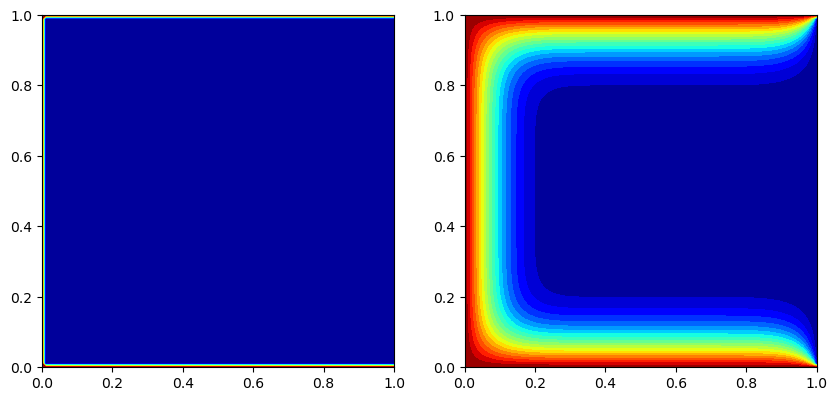

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,20))
ax1 = ax[0]
ax2 = ax[1]
im1 = ax1.contourf(X, Y, u_numpy, 20, cmap='jet')
ax1.set_aspect('equal')
im2 = ax2.contourf(X, Y, u_numpy_final, 20, cmap='jet')
ax2.set_aspect('equal')

In [15]:
# Numba test
u_numba = initialize_domain_serial(Nx, Ny)
u_numba[0,:] = h
u_numba[:,0] = h
u_numba[:,-1] = h
u_numba_final = simulation_loop_numba(u_numba, Cx, Cy, Nt) # %timeit for time results

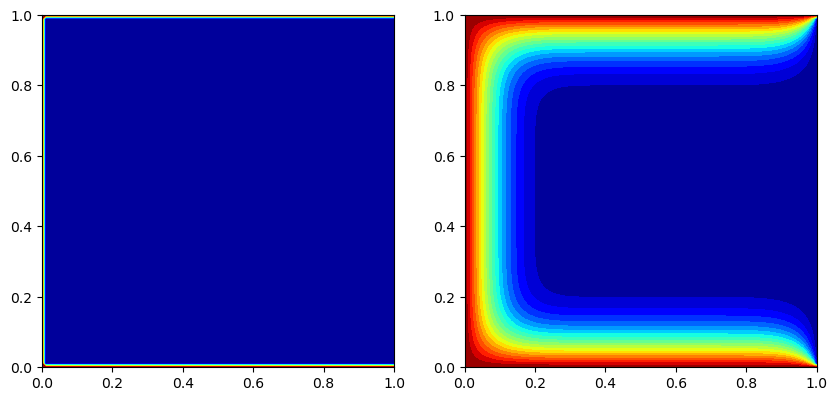

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,20))
ax1 = ax[0]
ax2 = ax[1]
im1 = ax1.contourf(X, Y, u_numba, 20, cmap='jet')
ax1.set_aspect('equal')
im2 = ax2.contourf(X, Y, u_numba_final, 20, cmap='jet')
ax2.set_aspect('equal')

## Working the solution with MPI

`ipyparallel` is a Python package that provides parallel computing tools for interactive computing with IPython. It allows you to execute code simultaneously across multiple engines, which can be running on a single machine or distributed across multiple machines. Here's an overview of its key features:

1. **Interactive Parallel Computing**: `ipyparallel` enables interactive parallel computing in IPython/Jupyter environments, allowing you to distribute computations across multiple processes or machines.

2. **Easy to Use**: It provides a simple and intuitive interface for parallel computing, making it easy to parallelize existing code or develop new parallel algorithms.

3. **IPython Integration**: As an extension to IPython, `ipyparallel` seamlessly integrates with IPython's interactive computing environment, providing parallel execution capabilities directly within IPython/Jupyter notebooks or IPython shells.

4. **Flexible Parallelism**: You can choose between different parallelism models, including task parallelism (where tasks are executed in parallel across engines) and data parallelism (where data is distributed across engines for parallel processing).

5. **Load Balancing**: `ipyparallel` includes load balancing mechanisms to evenly distribute tasks across available engines, ensuring efficient utilization of computing resources.

6. **Fault Tolerance**: It offers fault tolerance mechanisms to handle failures gracefully, such as automatic retry of failed tasks or the ability to resume computations from a checkpoint.

7. **Scalability**: `ipyparallel` scales from a single machine with multiple cores to clusters of machines, allowing you to leverage distributed computing resources to accelerate your computations.

8. **Extensibility**: It provides a flexible framework for building custom parallel computing workflows, allowing you to extend its functionality to suit your mputing resources.

In [17]:
#parallel processing in Jupyter
import ipyparallel as ipp

To correctly work the solution with MPI, we divide the domain using a cartesian topology for our processors or cores as we saw with Geert in the `mpi4py` section of the lectures.

![image.png](https://hpc-tutorials.llnl.gov/mpi/images/Cartesian_topology.gif)

In this case, we will use $N_{procs}=4$ so a 2 x 2 division of the physical domain. We need to ensure communication between processes so we'll keep the boundary cells for all subdomains like so, 

![image.png](https://www.researchgate.net/publication/7660293/figure/fig3/AS:667824355819525@1536233142844/Two-stages-of-a-halo-exchange-in-two-dimensions-Note-the-corner-is-transmitted-from.png)

It is important to specify that this problem is not periodic in the MPI cartesian topology creator function.

In [21]:
def Laplace_MPI(rows, cols, sim_params):

    from mpi4py import MPI
    import numpy as np
    import sys

    def apply_boundaries_rank(rank_coords, local_matrix, h):
        # Depending on the position of the processor on the cartesian logical 
        # apply the boundary conditions
        
        if rank_coords[0] == 0:
            local_matrix[0,:] = h
        
        if rank_coords[1] == 0:
            local_matrix[:,0] = h

        if rank_coords[1] == 1:
            local_matrix[:,-1] = h
        
        
        return local_matrix
    
    def halo_comm(cart_comm, local_matrix, left, right, up, down):
        # Halo exchange between all processors
    
        send_buffer_hor = local_matrix[1,:].copy()
        send_buffer_ver = local_matrix[:,1].copy()
        
        recv_buffer_hor = np.zeros_like(send_buffer_hor)
        recv_buffer_ver = np.zeros_like(send_buffer_ver)        
        
        cart_comm.Sendrecv(send_buffer_hor, recvbuf=recv_buffer_hor,
                           dest=left, source=right) # comm X direction right to left
        
        cart_comm.Sendrecv(send_buffer_ver, recvbuf=recv_buffer_ver,
                           dest=down, source=up) # comm X direction up to down
        
        local_matrix[-1,:] = recv_buffer_hor
        local_matrix[:,-1] = recv_buffer_ver

        send_buffer_hor = local_matrix[-2,:].copy()
        send_buffer_ver = local_matrix[:,-2].copy()

        cart_comm.Sendrecv(send_buffer_hor, recvbuf=recv_buffer_hor,
                           dest=right, source=left) # comm X direction left to right
        
        cart_comm.Sendrecv(send_buffer_ver, recvbuf=recv_buffer_ver,
                           dest=up, source=down) # comm X direction down to up
        
        local_matrix[0,:] = recv_buffer_hor
        local_matrix[:,0] = recv_buffer_ver
        
        return local_matrix

    def laplace_stencil2D_numpy(u, Cx, Cy):
        return (u[1:-1, 1:-1] + Cx *(u[:-2,1:-1] - 2.0*u[1:-1, 1:-1] + u[2:,1:-1]) +
            Cy *(u[1:-1,:-2] - 2.0*u[1:-1, 1:-1] + u[1:-1,2:]))
    
    comm = MPI.COMM_WORLD # get MPI comm
    size = comm.Get_size()
    rank = comm.Get_rank()
    comm_ghost_cells = 2
    
    if size % rows == 0: 
        cols = size // rows 
    else:
        if rank == root:
            msg = f'number of rows {rows} does not divide comm size {size}'
            print(f'number of rows {rows} does not divide comm size {size}', file=sys.stderr)
            comm.Abort(1)
            
    dims = [rows, cols]
    cart_comm = comm.Create_cart(dims, periods=[False, False])
    rank_coords = cart_comm.Get_coords(rank)
    
    left, right = cart_comm.Shift(0,1)
    up, down = cart_comm.Shift(1,-1)
    
    # get simulation parameters
    Nx = sim_params["Nx"]
    Ny = sim_params["Ny"]
    Nt = sim_params["Nt"]
    Lx = sim_params["Lx"]
    Ly = sim_params["Ly"]
    T = sim_params["T"]
    alpha = sim_params["alpha"]
    h = sim_params["h"]
    dx = Lx/Nx
    dy = Ly/Ny
    dt = T/Nt
    Cx = alpha*dt/dx**2
    Cy = alpha*dt/dy**2

    # plotting coordinates per proc    
    x = np.linspace(0, Lx/rows, Nx//rows + comm_ghost_cells) + rank_coords[0]*Lx/rows
    y = np.linspace(0, Ly/cols, Ny//rows + comm_ghost_cells) + rank_coords[1]*Ly/cols
    X, Y = np.meshgrid(x, y, indexing="ij")

    # allocate matrix per proc
    u_local = np.zeros((Nx//rows + comm_ghost_cells , Ny//cols + comm_ghost_cells))
    u_local = apply_boundaries_rank(rank_coords, u_local, h)

    # simulation loop 
    for i in range(Nt):
        # apply boundary conditions    
        u_local[1:-1,1:-1] = laplace_stencil2D_numpy(u_local, Cx, Cy)
        u_local = apply_boundaries_rank(rank_coords, u_local, h)
        halo_comm(cart_comm, u_local, left, right, up, down) # Waits until exchange ends
        u_local = apply_boundaries_rank(rank_coords, u_local, h)
        
    return (u_local, X, Y, (rank_coords[0]*Lx/rows, rank_coords[1]*Ly/cols), 
            rank, rank_coords, (left, right, up, down))

# param definitions 
sim_params = {
    "Nx" : 100,
    "Ny" : 100,
    "Nt" : 250,
    "Lx" : 1.0,
    "Ly" : 1.0,
    "T" : 50,
    "alpha" : 1.0e-4,
    "h" : 300 #K
}

In [28]:
# request an MPI cluster with 4 engines
with ipp.Cluster(engines='mpi', n=4) as rc:
    # get a broadcast_view on the cluster which is best
    # suited for MPI style computation
    view = rc.broadcast_view()
    # run the laplaceMPI function on all engines in parallel
    r = view.apply_sync(Laplace_MPI, 2, 2, sim_params)
    # Retrieve and print the result from the engines
    # at this point, the cluster processes have been shutdown

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|███████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.42s/engine]
Stopping engine(s): 1707754912
engine set stopped 1707754912: {'exit_code': 0, 'pid': 2776, 'identifier': 'ipengine-1707754911-h2ee-1707754912-530'}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 2740, 'identifier': 'ipcontroller-1707754911-h2ee-530'}


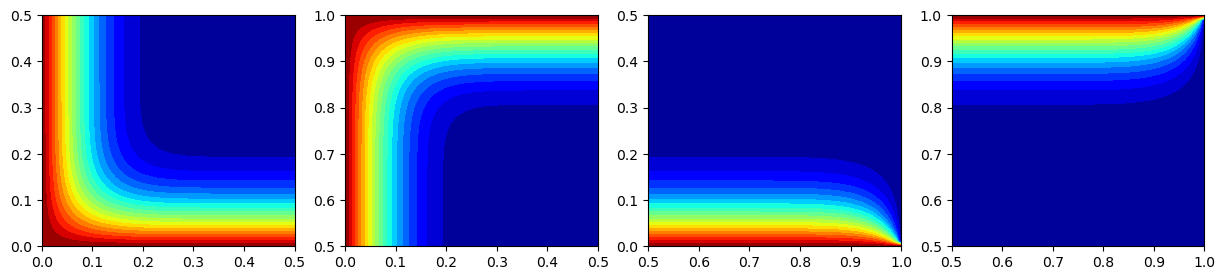

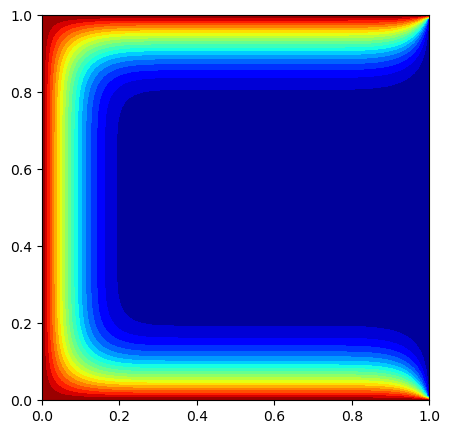

In [35]:
vmin = 0
vmax = 0
for p in r:
    u, _, _, _, _, _, _ = p 
    if vmin > u.min():
        vmin = u.min()
    if vmax < u.max():
        vmax = u.max()

# plot individual solutions
fig, ax = plt.subplots(1,len(r),figsize=(15,3))

for i,p in enumerate(r):
    u, X, Y, _, _, _, _ = p
    # print(ran," ", rank)
    # print(rank_coords)
    # print(neighs) used to debug communication
    ax[i].contourf(X, Y, u, 20, cmap='jet', vmin=vmin, vmax=vmax)
plt.show()
plt.close()
    
fig, ax = plt.subplots(figsize=(5,5))
#plot all outputs on the same graph
for p in r:
    u, X, Y, ran, rank, rank_coords, neighs = p
    # print(ran," ", rank)
    # print(rank_coords)
    # print(neighs) used to debug communication
    plt.contourf(X, Y, u, 20, cmap='jet', vmin=vmin, vmax=vmax)

plt.show()
plt.close()